In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')



In [54]:
# Load the cleaned data
data = pd.read_csv('cleaned_data.csv', parse_dates=['Date'], index_col='Date')
data.head()

,Price
Date,
2012-01-01,99
2012-01-02,95
2012-01-03,96
2012-01-04,95
2012-01-05,93


Text(0.5, 1.0, 'Time Series Data')

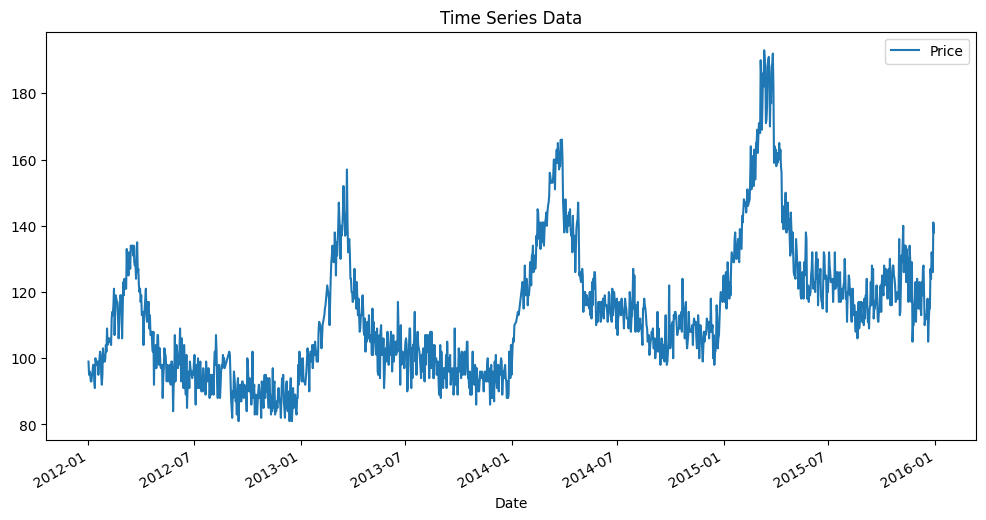

In [55]:
# Plot the time series
data.plot(figsize=(12, 6))
plt.title('Time Series Data')

### Test for Stationarity

We'll use the dicky-fuller test to find out if the data is stationary.

In [56]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

In [57]:
check_stationarity(data['Price'])

ADF Statistic: -2.9292828197545466
p-value: 0.04204723667393765
The series is stationary.


### Observation

The ADF test shows that the data is stationary, however we can clearly observe seasonality in the data year-on-year , we will perform seasonal differencing for finding a lower p-value.

In [59]:
# Also test seasonally differenced series
seasonal_diff = data['Price'].diff(365).dropna()
adf_seasonal = check_stationarity(seasonal_diff)

ADF Statistic: -3.8549422609235857
p-value: 0.0023926414071660683
The series is stationary.


p-value of the seasonal differenced series is the least , hence we will use it.

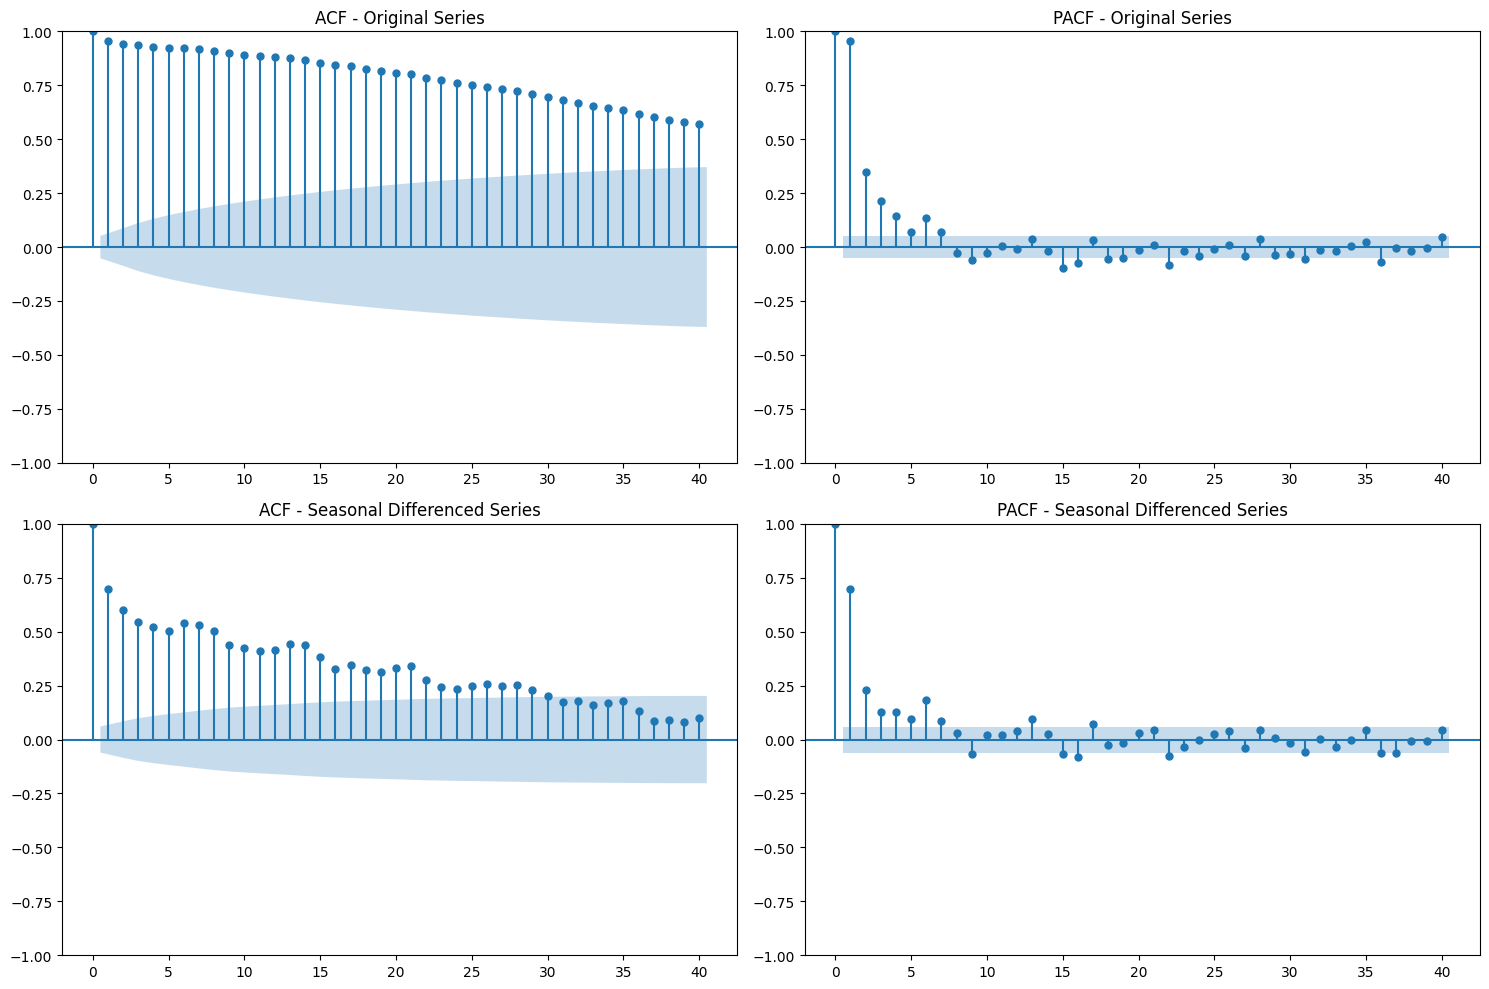

In [60]:
# Use the most stationary series (usually combined difference)
stationary_series = seasonal_diff

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF and PACF for original series
plot_acf(data['Price'].dropna(), ax=axes[0,0], lags=40, title='ACF - Original Series')
plot_pacf(data['Price'].dropna(), ax=axes[0,1], lags=40, title='PACF - Original Series')

# ACF and PACF for differenced series
plot_acf(stationary_series, ax=axes[1,0], lags=40, title='ACF - Seasonal Differenced Series')
plot_pacf(stationary_series, ax=axes[1,1], lags=40, title='PACF - Seasonal Differenced Series')

plt.tight_layout()
plt.show()

## ARIMA Parameters
Based on the ACF and PACF plots we can observe the following hyperparamters for the ARIMA Model-

ACF Analysis (Very Clear Pattern):
- Lag 1: Very significant (~0.7)
- Lag 2-10: Exponential/geometric decay pattern
→ Suggests: q = 0 or q = 1 (minimal MA component needed)

PACF:
- Lag 1: Highly significant (~0.7)
- Lag 2: Significant (~0.23) 
- Lag 3: Borderline significant (~0.13)
- Lag 4: Small spike (~0.08)
- Lag 5+: Within confidence bands
→ Suggests: p = 2 (clear cutoff after lag 2)

Hence The best model candidates are =
q=[0,1]
p=[2]
d=[0] ( based on stationarity test earlier)

## Seasonality Check

As we did observe yearly seasonality in the data visually it is important to check if we want to use SARIMA model to achieve a better fit. so we will plot the ACF and PACF plots with a lag > 365

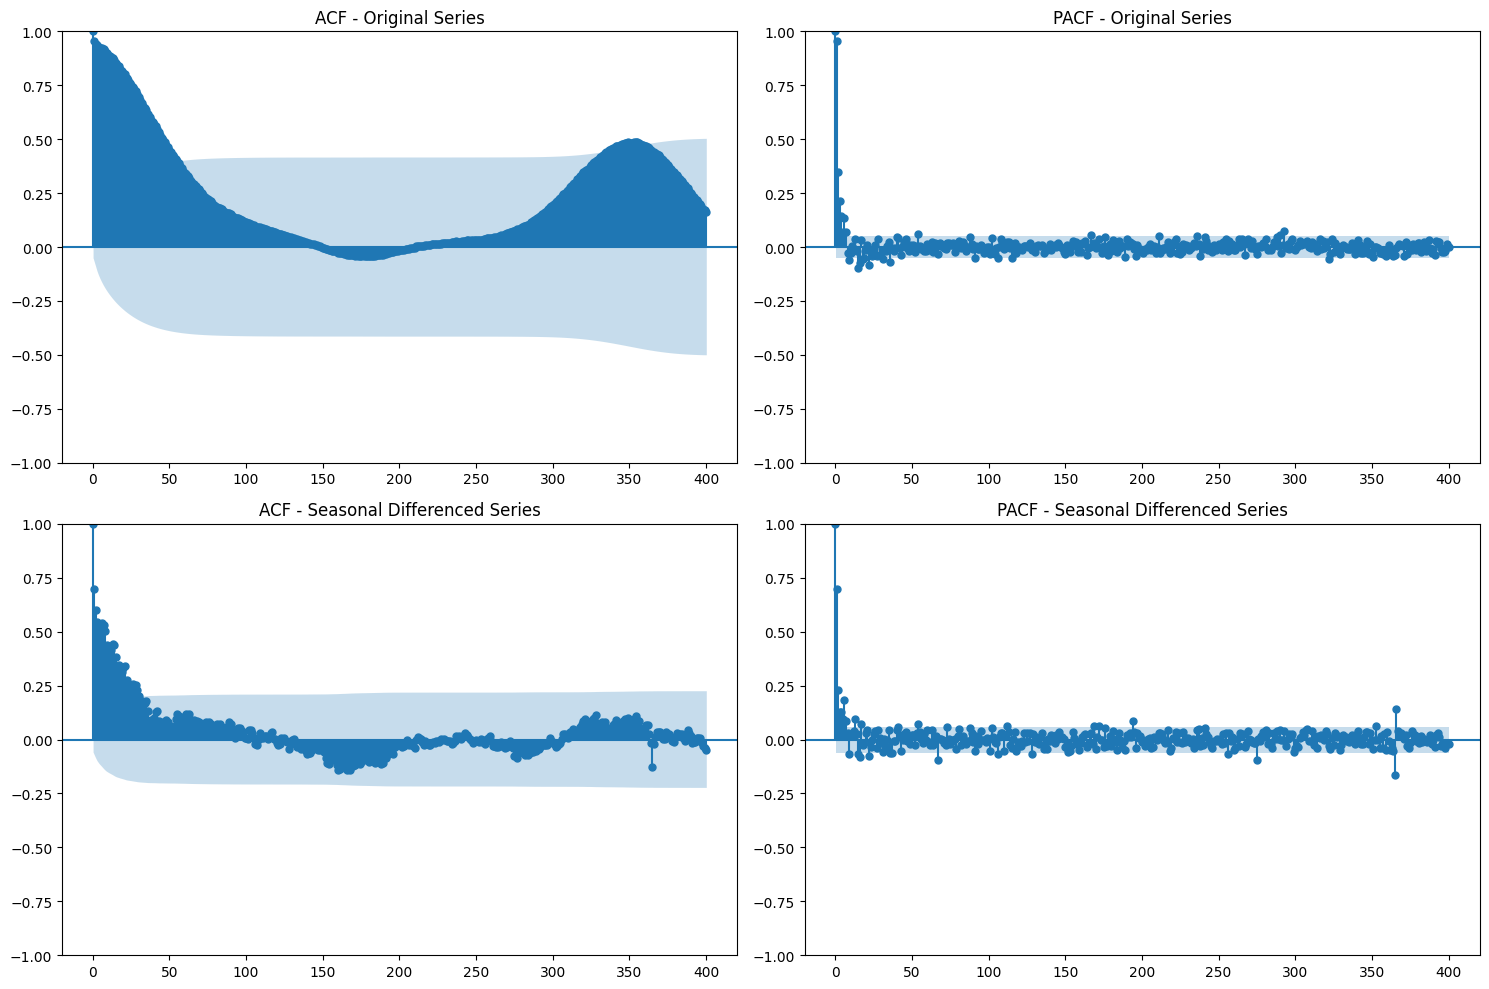

In [61]:
# Use the most stationary series (usually combined difference)
stationary_series = seasonal_diff

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF and PACF for original series
plot_acf(data['Price'].dropna(), ax=axes[0,0], lags=400, title='ACF - Original Series')
plot_pacf(data['Price'].dropna(), ax=axes[0,1], lags=400, title='PACF - Original Series')

# ACF and PACF for differenced series
plot_acf(stationary_series, ax=axes[1,0], lags=400, title='ACF - Seasonal Differenced Series')
plot_pacf(stationary_series, ax=axes[1,1], lags=400, title='PACF - Seasonal Differenced Series')

plt.tight_layout()
plt.show()

### Observation
using the ACF and PACF plots, we can see strong seasonlity indicator with a lag of 365 , however training an ARIMA/SARIMA model with such high lag value is very computationally expensive , hence we will use a different approach 
We will try using meta's Prophet model which is designed to handle long seasonal patterns and is computationally less expensive


### Training Prophet Model

In [62]:
train_split = 0.8
train_data = data['Price'][:int(len(data)*train_split)]
test_data = data['Price'][int(len(data)*train_split):]

In [63]:
# Prepare data for Prophet
# Prophet requires columns named 'ds' (datestamp) and 'y' (target variable)
def prepare_prophet_data(data_series, name='y'):
    """Convert pandas series to Prophet format"""
    df = pd.DataFrame({
        'ds': data_series.index,
        'y': data_series.values
    })
    return df

# Prepare training and test data
train_prophet = prepare_prophet_data(train_data)
test_prophet = prepare_prophet_data(test_data)

print("Preparing data for Prophet...\n")

# Create Prophet model with various seasonalities
model = Prophet(
    yearly_seasonality=True,      
    weekly_seasonality=False,      
    daily_seasonality=False,      
    seasonality_mode='multiplicative',  
    changepoint_prior_scale=0.05, 
    seasonality_prior_scale=10,   
    interval_width=0.95,          
    growth='linear'              
)


# Fit the model
model.fit(train_prophet)
print("Model training completed")

# Create future dataframe for predictions
# This includes the test period dates
future = model.make_future_dataframe(periods=len(test_data), freq='D')  # Adjust freq as needed

# Make predictions
print(f"\nGenerating predictions...")
forecast = model.predict(future)

# Extract test period predictions
train_size = len(train_data)
test_predictions = forecast.iloc[train_size:].copy()

# Calculate metrics
y_true = test_data.values
y_pred = test_predictions['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\n Prophet Model Performance:")
print(f"   MAE:  {mae:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   MAPE: {mape:.2f}%")


16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:25 - cmdstanpy - INFO - Chain [1] done processing


Preparing data for Prophet...

Model training completed

Generating predictions...

 Prophet Model Performance:
   MAE:  9.0242
   RMSE: 10.4308
   MAPE: 7.39%


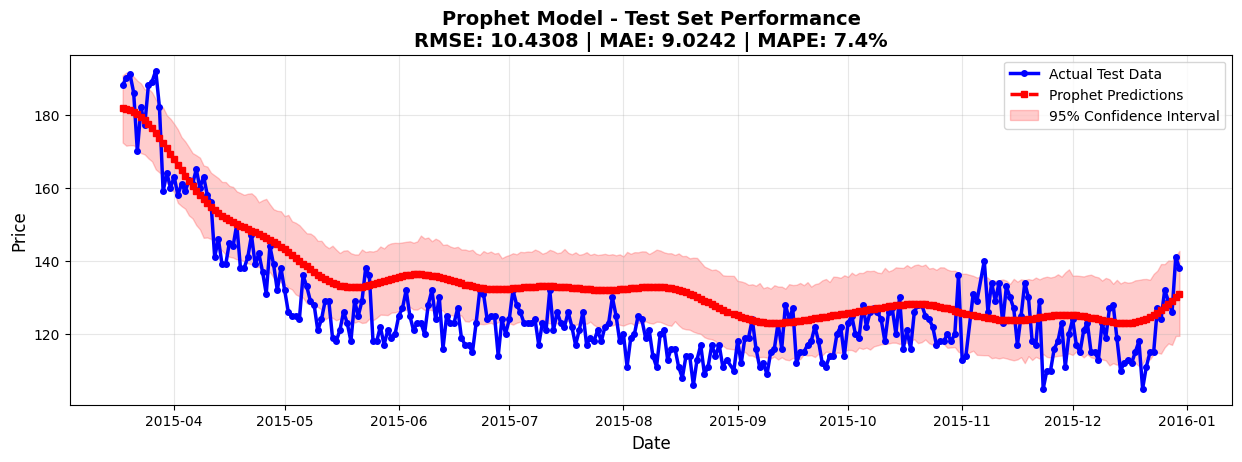

In [64]:
# Create visualization
plt.figure(figsize=(15, 10))


plt.subplot(2, 1, 1)

plt.plot(test_data.index, test_data.values, 
          color='blue', label='Actual Test Data', linewidth=2.5, marker='o', markersize=4)

plt.plot(test_data.index, y_pred, 
          color='red', label='Prophet Predictions', linewidth=2.5, linestyle='--', marker='s', markersize=4)

# Plot confidence intervals
plt.fill_between(test_data.index,
                  test_predictions['yhat_lower'].values,
                  test_predictions['yhat_upper'].values,
                  color='red', alpha=0.2, label='95% Confidence Interval')

plt.title(f'Prophet Model - Test Set Performance\nRMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.1f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

### Forecast for Feb 2022

In [65]:
# Create February 2022 date range
feb_2022_start = pd.Timestamp('2022-02-01')
feb_2022_end = pd.Timestamp('2022-02-28')


# Calculate periods to forecast
last_train_date = train_data.index[-1]
periods_to_feb = (feb_2022_end - last_train_date).days

# Create future dataframe and predict
future = model.make_future_dataframe(periods=periods_to_feb, freq='D')
forecast = model.predict(future)


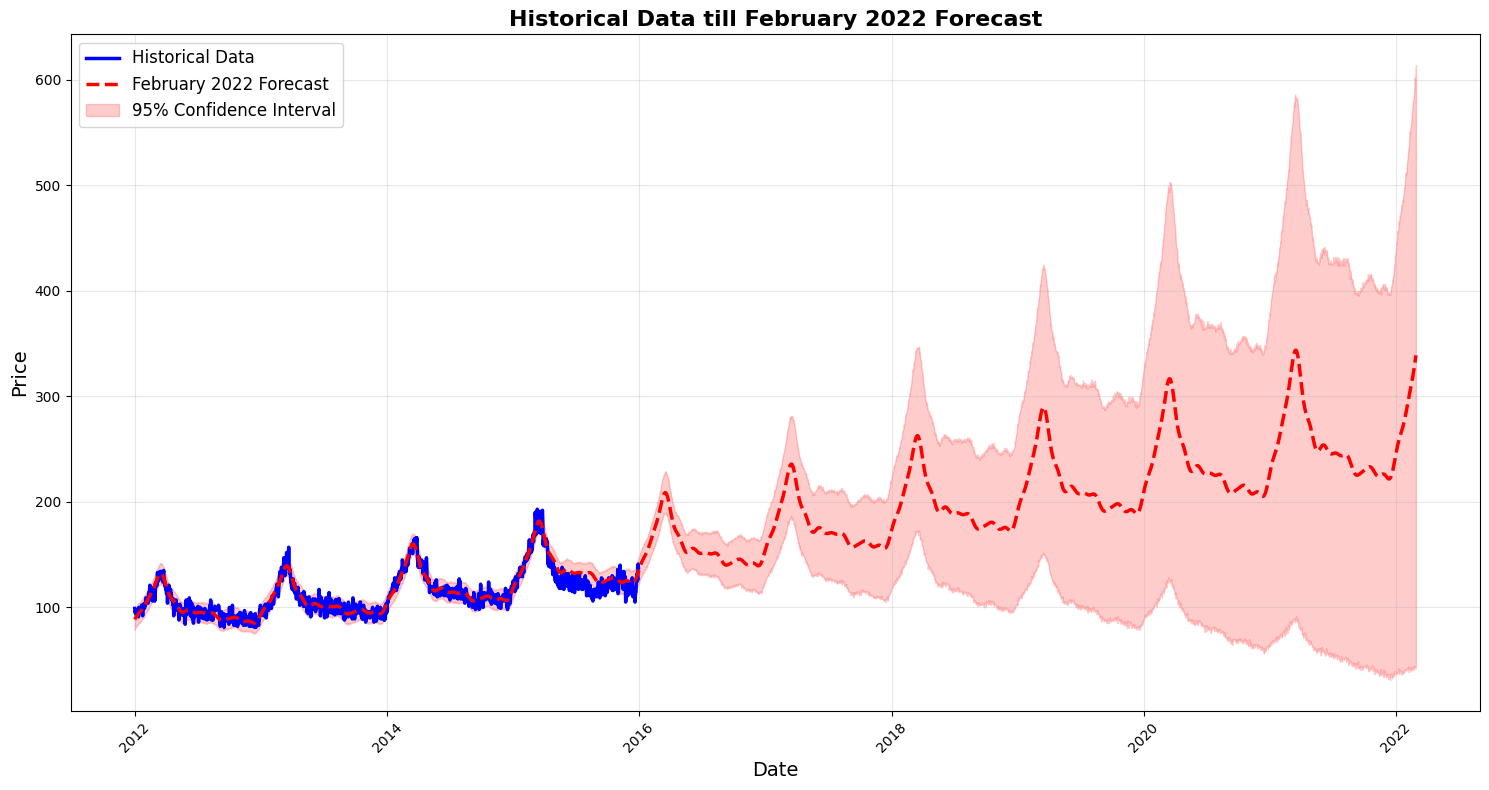

In [66]:
# plot the whole series with forecast
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['Price'], 
         color='blue', label='Historical Data', linewidth=2.5)
plt.plot(forecast['ds'], forecast['yhat'],
         color='red', label='February 2022 Forecast', linewidth=2.5, linestyle='--')
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Historical Data till February 2022 Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:

# Extract February 2022 data
feb_mask = (forecast['ds'] >= feb_2022_start) & (forecast['ds'] <= feb_2022_end)
feb_forecast = forecast[feb_mask].copy()

# Create forecast table
forecast_table = pd.DataFrame({
  'Date': feb_forecast['ds'].dt.strftime('%Y-%m-%d'),
  'Predicted_Price': feb_forecast['yhat'].round(3),
  'Lower_Bound': feb_forecast['yhat_lower'].round(3),
  'Upper_Bound': feb_forecast['yhat_upper'].round(3)
})

print("\n📋 February 2022 Daily Forecasts:")
print(forecast_table.to_string(index=False))
# save the forecast table to CSV
forecast_table.to_csv('february_2022_forecast.csv', index=False)



📋 February 2022 Daily Forecasts:
      Date  Predicted_Price  Lower_Bound  Upper_Bound
2022-02-01          287.460       40.451      514.692
2022-02-02          289.238       42.660      521.402
2022-02-03          291.030       43.583      523.743
2022-02-04          292.827       40.796      525.662
2022-02-05          294.623       43.945      529.590
2022-02-06          296.411       38.693      534.520
2022-02-07          298.186       41.349      534.207
2022-02-08          299.946       43.131      539.857
2022-02-09          301.688       41.219      546.800
2022-02-10          303.413       41.338      551.542
2022-02-11          305.123       41.081      548.525
2022-02-12          306.821       43.022      554.500
2022-02-13          308.513       39.471      556.838
2022-02-14          310.207       40.247      558.582
2022-02-15          311.910       42.837      561.428
2022-02-16          313.632       40.890      566.702
2022-02-17          315.382       40.833      56